#### About
GAN based Image generation.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
# os.chdir('/content/drive/MyDrive/Datasets')
# !unzip data.zip

In [2]:
#importing modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid
import numpy as np
import glob

from tqdm.notebook import tqdm
from torchvision.utils import save_image

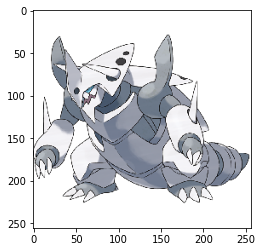

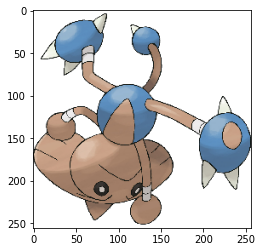

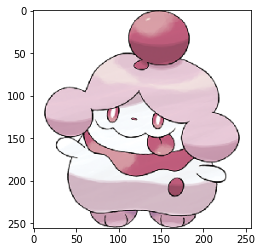

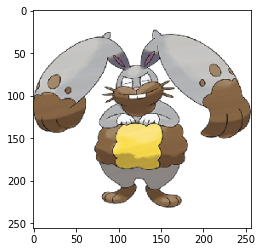

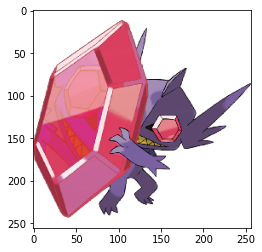

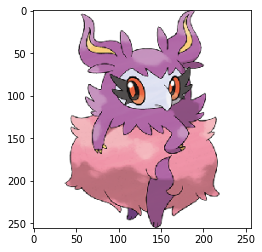

In [3]:
dataset_path = "/content/drive/MyDrive/Datasets/data/"
disp_count = 1
for filename in glob.glob(dataset_path+"/pokemon/*.png"):
    plt.imshow(plt.imread(filename))
    plt.show()
    if disp_count==6:
        break
    disp_count+=1

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
image_size = 64
batch_size=256
vals = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) #traiining models in pixel value at -1 to 1 is better
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(*vals)])

In [6]:
#creating dataset
dataset = ImageFolder(dataset_path, transform=transform)
dataset.__getitem__(255)

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]), 0)

In [7]:
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
#function to denormalise the images
def denorm(image_tensor):
    return image_tensor * vals[1][0] + vals[0][0]

In [9]:
#function to visualise
def display_images(images, max=32):
    fig,ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:max]),nrow=8).permute(1,2,0))

def display_batch(dataloader, max=32):
    for images, _ in dataloader:
        display_images(images,max)
        break

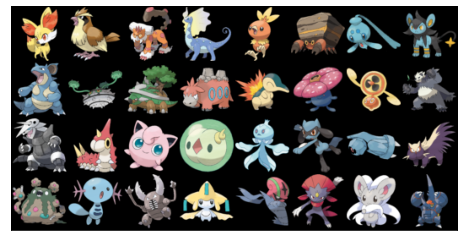

In [10]:
display_batch(dataloader)

## 1. Discriminator Network
It takes an image as input and tries to classify whether it belongs to the dataset or not. If it belongs to then 1 is assigned i.e real else fake or 0.

In [11]:
discriminator_network = nn.Sequential(
    nn.Conv2d(3,64,kernel_size=4,stride=2, padding=1,bias=False), #bias = False for batch norm
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),


    nn.Conv2d(64,128,kernel_size=4,stride=2, padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(128,2*128,kernel_size=4,stride=2, padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(256,512,kernel_size=4,stride=2, padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(512,1,kernel_size=4,stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid() 
)

In [12]:
d_model = discriminator_network.to(device)

## 2. Generator model
It takes in a latent single dimension vector and upsamples it to generate an image. Each element in the latent vector can be considered to represent unique feature like eye, eyebrow, nose, ear etc.

In [13]:
latent_size = 128
generator = nn.Sequential(

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()

)

In [14]:
g_model = generator.to(device)

In [15]:
# generating a random sample of fake images
x = torch.randn(batch_size,latent_size,1,1).to(device)
fake_images = g_model(x).detach().cpu().numpy()
#display_images(fake_images)

Clearly, Since Generator is not trained so it's bound to yield noise.

#### Training functions
1. Discriminator training
> Objective
* Train discriminator to identify which images belong to dataset and which don't by correctly assigning tensors of 0 or 1 for fake and real images

In [16]:
def discriminator_training(real_images, optimizer_discriminator):
    optimizer_discriminator.zero_grad()

    # passing real images through discriminator
    real_preds = d_model(real_images)
    #assign tensor of ones for these 
    real_targets = torch.ones(real_images.size(0),1,device=device)
    real_loss = torch.nn.functional.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # generating fake images and assigning tensor of zeros for them as targets
    latent_vector = torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images = g_model(latent_vector)

    #passing fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0),1, device=device)
    fake_preds = d_model(fake_images)
    fake_loss = torch.nn.functional.binary_cross_entropy(fake_preds,fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # updating discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    optimizer_discriminator.step()

    return loss.item(), real_score, fake_score

#### 2. Generator Training
> Objective
* The objective is to train a generator which have labels as 1 for generated images so as to fool the discriminator. The generator should be able to generate such images eventually which can fool the discriminator.

In [25]:
def generator_training(generator_optimizer):
    generator_optimizer.zero_grad()

    #generate fake images
    latent_vector = torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images = generator(latent_vector)

    # try to fool the discriminator
    preds = d_model(fake_images)
    targets = torch.ones(batch_size,1,device=device)
    loss = torch.nn.functional.binary_cross_entropy(preds,targets)

    #updating weights
    loss.backward()
    generator_optimizer.step()

    return fake_images,loss.item()


In [32]:
#logging images
os.makedirs('generated_images', exist_ok=True)

def save_generated_images(index, fake_images, show=True):
    fake_filename = 'generated-images-{0:0=6d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join('generated_images', fake_filename),nrow=8)
    print("Saved image")
    if show:
        fig,ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(),nrow=8).permute(1,2,0))

#### Trainer

In [33]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
def trainer(epochs,dataloader, learning_rate,start_idx=1):
    #losses,scores
    g_losses, d_losses= [],[]
    real_scores,fake_scores = [],[]

    #creating optimizers
    d_opt = optim.Adam(d_model.parameters(),lr=learning_rate, betas=(0.5, 0.999))
    g_opt = optim.Adam(g_model.parameters(),lr=learning_rate, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(dataloader):
            #train discriminator
            real_images = real_images.to(device)
            d_loss, real_score,fake_score = discriminator_training(real_images,d_opt)
            #train generator
            pred,g_loss = generator_training(g_opt)

        #recording losses
        g_losses.append(g_loss)
        d_losses.append(d_loss)

        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, g_loss, d_loss, real_score, fake_score))
        
        

        #saving generated images
        save_generated_images(epoch+start_idx, pred,show=False)

    return g_losses,d_losses,real_scores,fake_scores




In [ ]:
learning_rate=1e-5
epochs=100
history = trainer(epochs,dataloader,learning_rate)

  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/100], loss_g: 8.6187, loss_d: 0.0009, real_score: 0.9994, fake_score: 0.0003
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 8.8449, loss_d: 0.0004, real_score: 0.9998, fake_score: 0.0002
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 9.0307, loss_d: 0.0004, real_score: 0.9998, fake_score: 0.0002
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 9.2092, loss_d: 0.0003, real_score: 0.9999, fake_score: 0.0002
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 9.3767, loss_d: 0.0003, real_score: 0.9999, fake_score: 0.0001
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 9.4266, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0001
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 9.5888, loss_d: 0.0002, real_score: 0.9999, fake_score: 0.0001
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 9.7108, loss_d: 0.0002, real_score: 0.9999, fake_score: 0.0001
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 9.7885, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0001
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 9.8852, loss_d: 0.0002, real_score: 0.9999, fake_score: 0.0001
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 9.9202, loss_d: 0.0002, real_score: 0.9999, fake_score: 0.0001
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 10.0669, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0001
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 10.1078, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0001
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 10.1458, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 10.1795, loss_d: 0.0002, real_score: 0.9999, fake_score: 0.0001
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 10.2425, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 10.2701, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0001
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 10.2763, loss_d: 0.0002, real_score: 0.9999, fake_score: 0.0001
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 10.3323, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0001
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

In [30]:
#!rm -rf /content/generated_images

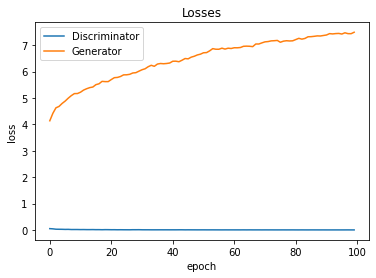

In [35]:
losses_g, losses_d, real_scores, fake_scores = history
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

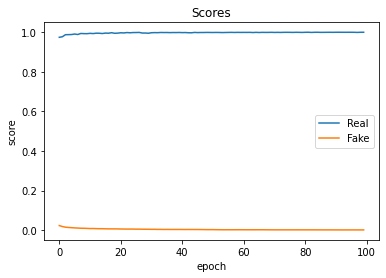

In [36]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [37]:
torch.save(g_model.state_dict(), 'G.pth')
torch.save(d_model.state_dict(), 'D.pth')